### Import helper functions

In [75]:
from plot_helpers import show_image, plot_results, scatter
from dataset_helpers import dataset_split, filenames_to_labels
from dataset_helpers import sliding_window, images_to_dataset, read_folder_filenames
from dataset_helpers import reshape, center_crop, normalise, preprocess, get_label

import matplotlib.pyplot as plt
import numpy as np
import os, copy
%matplotlib inline

imw = 192
imh = 192
c = 1
RS = 2211

In [76]:
from sklearn.manifold import TSNE
from keras.layers import Input, BatchNormalization, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Reshape, LeakyReLU
from keras.models import Model
from keras import backend as K

### Read dataset

In [78]:
npzfile = np.load('/Volumes/TARDIS/dmso_unmodified.npz')

In [102]:
x = npzfile['x']

In [103]:
y = npzfile['y']

In [82]:
x_dmso = copy.deepcopy(x)

In [105]:
for idx, i in enumerate(x_dmso):
    x_dmso[idx] = test(i)
    x_dmso[idx] /= np.max(x_dmso[idx])

In [6]:
x_dmso = np.reshape(DMSO_dataset, (len(DMSO_dataset), imw, imh, 1))

In [317]:
def get_training_sets(dataset, labels, test_size=0.2):
    # x_train and x_test need to be kept in same order 
    # as we need to do pairwise overlap calculations
    x_train, x_test, y_train, y_test = dataset_split(dataset, labels, test_size=test_size)

    x_train = np.reshape(x_train, (len(x_train), imw, imh, c))
    x_test = np.reshape(x_test, (len(x_test), imw, imh, c))
    return x_train, x_test, y_train, y_test

In [318]:
# x_train and x_test need to be kept in same order 
# as we need to do pairwise overlap calculations
x_train, x_test, y_train, y_test = get_training_sets(dataset, labels, test_size=0.2)

### Image augmentation

In [12]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=360,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
    )
itr = train_datagen.flow(
x_train, y_train,
batch_size=x_train.size)

X, y = itr.next()

In [27]:
x_big = np.concatenate((x_train, X), axis=0)
y_big = np.concatenate((y_train, y), axis=0)

(3336, 192, 192, 1)

### Helper functions for evaluating models

In [121]:
plt.rcParams.update({'axes.titlesize': 'medium'})

def run_evaluation(model, data, test, batch_size=48, epochs=30, visualise=False):
    # visualise feature maps
    if visualise:
        visualise_activations(model, data)
    
    # get model image predictions before training
    # @QUESTION: is this a good strategy?
    decoded_before = model.predict(data[21:22])
    test_decoded_before = model.predict(test[21:22])

    # fit model; get before/after weights (make sure there is a change)
    untrained_weights = [np.min(model.get_layer(index=1).get_weights()[0]), np.max(model.get_layer(index=1).get_weights()[0])]
    loss = model.fit(data, data, epochs=epochs, batch_size=batch_size)
    trained_weights = [np.min(model.get_layer(index=1).get_weights()[0]), np.max(model.get_layer(index=1).get_weights()[0])]
    
    # plot the loss
    plt.figure()
    plt.plot(loss.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    
    
    # show the difference in reconstruction
    decoded_imgs = model.predict(data[21:22]) # test on images it trained on
    untrained_decoded = model.predict(test[21:22]) # test images

    s=12
    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 3, 1)
    show_image(reshape(data[21], w=imw, h=imh, c=c), "original training image")
    fig.add_subplot(1, 3, 2)
    show_image(reshape(decoded_imgs[0], w=imw, h=imh, c=c), "reconstructed - after")
    fig.add_subplot(1, 3, 3)
    show_image(reshape(decoded_before[0], w=imw, h=imh, c=c), "reconstructed - before")

    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 3, 1)
    show_image(reshape(test[21], w=imw, h=imh, c=c), "original test image")
    fig.add_subplot(1, 3, 2)
    show_image(reshape(untrained_decoded[0], w=imw, h=imh, c=c), "reconstructed test - after")
    fig.add_subplot(1, 3, 3)
    show_image(reshape(test_decoded_before[0], w=imw, h=imh, c=c), "reconstructed test - before")
              
    # see if weights have changed
    print("Weight difference: {}".format(np.array(untrained_weights)-np.array(trained_weights)))

In [14]:
# credit: https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

def visualise_activations(model, images):
    idx = np.random.randint(1, len(images)+1)
    l = len(model.layers)
    layer_outputs = [layer.output for layer in model.layers[1:l]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    # Choose random image to predict for
    activations = activation_model.predict(images[idx-1:idx])

    layer_names = []
    for layer in model.layers[1:l]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                              :, :,
                                              col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 65535).astype('uint16')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                          row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

In [16]:
from keract import get_activations, display_activations

def activations(model, images):
    j = np.random.randint(2, len(images))
    l = len(model.layers)
    layer_outputs = [layer.output for layer in model.layers[1:]]
    layer_names = [layer.name for layer in model.layers[1:]]

    for idx, layer in enumerate(layer_outputs):
        activation_model = Model(inputs=model.input, outputs=layer_outputs)
        activation_model.compile(optimizer="adam", loss="binary_crossentropy")
        activations = get_activations(activation_model, images[j-1:j], layer_names[idx])
        display_activations(activations, cmap="gray", save=False)

### Build autoencoder model

In [142]:
input_img = Input(shape=(imw, imh, 1))  # adapt this if using `channels_first` image data format

x =  Conv2D(64, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)
#encoded = x

x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x =  Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# this will help going back the original image dimensions
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), padding='same')(x)

In [188]:
# try model with strided convolutions rather than maxpooling

input_img = Input(shape=(imw, imh, 1))  # adapt this if using `channels_first` image data format

x =  Conv2D(64, (5, 5), strides=2, activation='relu',padding='same')(input_img)
x = Conv2D(32, (5, 5), strides=2, padding='same')(x)
x = Activation('sigmoid')(x)
x = Conv2D(16, (2, 2), strides=2, activation='relu', padding='same')(x)
encoded = Flatten()(x)
#encoded = x

x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x =  Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# this will help going back the original image dimensions
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), padding='same')(x)

In [110]:
# model from knot classifier

input_img = Input(shape=(imw, imh, c))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

In [111]:
decoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

In [112]:
decoder = Model(input_img, decoded)
decoder.compile(optimizer='adam', loss='binary_crossentropy')

In [114]:
decoder.fit(x_dmso[:100], x_dmso[:100], epochs=10)
decoded_imgs = decoder.predict(x_dmso[0:5])

Epoch 1/10
100/100 [==============================] - 4s 40ms/step - loss: 0.6947
Epoch 2/10
100/100 [==============================] - 3s 33ms/step - loss: 0.6887
Epoch 3/10
100/100 [==============================] - 4s 44ms/step - loss: 0.6816
Epoch 4/10
100/100 [==============================] - 5s 53ms/step - loss: 0.6691
Epoch 5/10
100/100 [==============================] - 3s 34ms/step - loss: 0.6456
Epoch 6/10
100/100 [==============================] - 4s 39ms/step - loss: 0.6111
Epoch 7/10
100/100 [==============================] - 5s 47ms/step - loss: 0.5570
Epoch 8/10
100/100 [==============================] - 4s 41ms/step - loss: 0.4930
Epoch 9/10
100/100 [==============================] - 4s 35ms/step - loss: 0.4383
Epoch 10/10
100/100 [==============================] - 3s 34ms/step - loss: 0.4242


In [56]:
encoder = Model(input_img, decoder.get_layer(index=9).output)

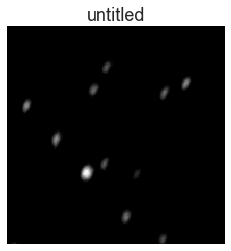

In [117]:
show_image(x_dmso[1, :, :, 0])

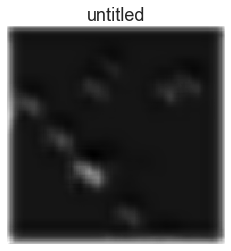

In [118]:
show_image(decoded_imgs[1, :, :, 0])

### TSNE code on own dataset

In [186]:
# https://www.datacamp.com/community/tutorials/introduction-t-sne
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=12, learning_rate=200, random_state=RS).fit_transform(x_overlap)

(<Figure size 576x576 with 1 Axes>,
 [Text(1.9308816, 0.94870734, '0'),
  Text(-2.950614, -0.007576411, '1'),
  Text(0.5641454, 0.7514255, '2'),
  Text(-1.4550862, 1.4340439, '3')])

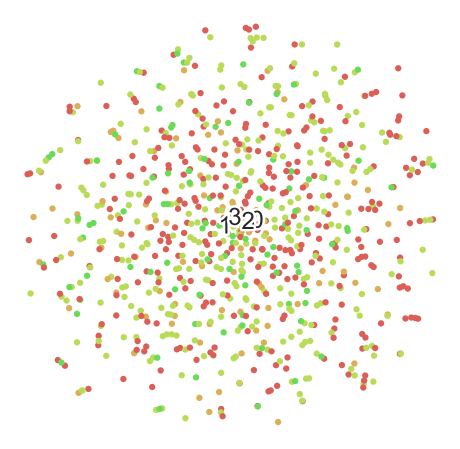

In [187]:
# after fixing overlap function

scatter(tsne, y_overlap)

In [51]:
# https://www.datacamp.com/community/tutorials/introduction-t-sne
from sklearn.manifold import TSNE

tsne = TSNE(random_state=RS).fit_transform(x_overlap)

(<Figure size 576x576 with 1 Axes>,
 [Text(4.975341, -10.336546, '0'),
  Text(-12.279524, 24.514067, '1'),
  Text(4.2586923, -9.231358, '2'),
  Text(4.6639204, -9.599739, '3')])

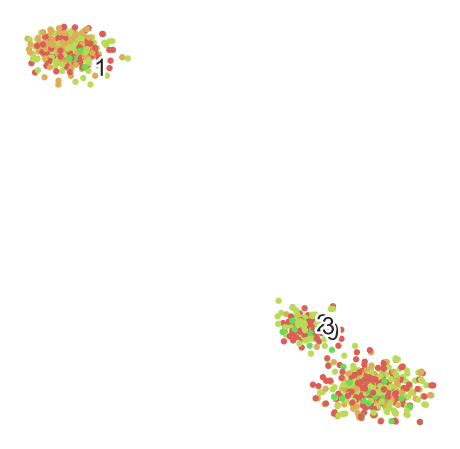

In [60]:
# before fixing overlap function
scatter(tsne, y_overlap)

In [25]:
x_dmso = np.reshape(x_)

(196, 200, 200, 1)

In [23]:
import umap.umap_ as umap
reducer = umap.UMAP()
embeddings = reducer.fit_transform(DMSO_dataset)

ValueError: Found array with dim 3. Estimator expected <= 2.

(<Figure size 576x576 with 1 Axes>,
 [Text(-2.2661724, 1.0799658, '0'),
  Text(12.14735, 0.79522675, '1'),
  Text(-2.1294107, 1.0460321, '2'),
  Text(-2.330204, 1.6459184, '3')])

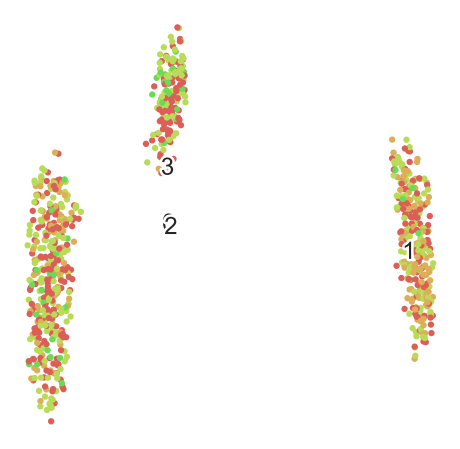

In [18]:
scatter(embeddings, y_overlap)

### View filters; code snippets

In [ ]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

In [ ]:
# redefine model to output right after the first hidden layer
feature_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        plt.figure()
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1

### Run own code on MNIST dataset

In [7]:
import numpy as np
import pandas as pd

from keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

RS = 20191458

Using TensorFlow backend.


In [36]:
from keras.datasets import mnist
(x_train, y_train), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [13]:
compressed_digits = encoder.predict(x_train)

In [15]:
x_sample, y_sample = compressed_digits[:1000], y_train[:1000]

In [16]:
digits_proj = TSNE(random_state=RS).fit_transform(x_sample)

(<Figure size 576x576 with 1 Axes>,
 [Text(-23.434824, -24.07652, '0'),
  Text(0.8921342, 36.784325, '1'),
  Text(-3.4372888, -14.56851, '2'),
  Text(-18.846968, -2.4877715, '3'),
  Text(24.522135, -7.741519, '4'),
  Text(-12.719883, 4.7274294, '5'),
  Text(2.67167, -32.721523, '6'),
  Text(25.147923, 17.10795, '7'),
  Text(-26.502972, 13.967726, '8'),
  Text(21.978443, 4.1691303, '9')])

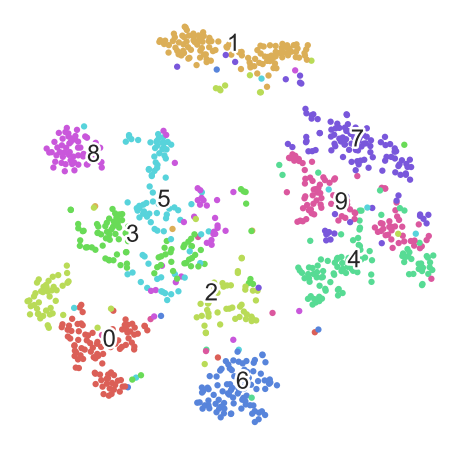

In [18]:
scatter(digits_proj, y_sample)